In [1]:
# 数据处理及可视化
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler,MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost
import lightgbm
from scipy import stats
from scipy.stats import skew
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)

In [2]:
# 获取训练数据与测试数据
train = pd.read_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/test.csv")
sample_submission = pd.read_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/sample_submission.csv")

In [3]:
train.shape,test.shape

((1460, 81), (1459, 80))

In [4]:
train.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice          int64
Length: 81, dtype: object

<AxesSubplot:>

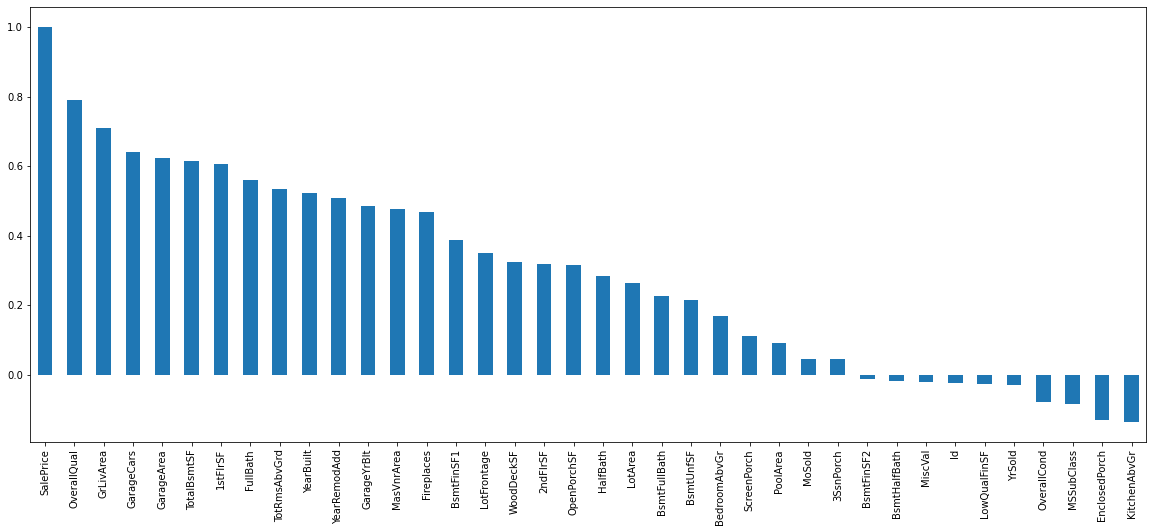

In [5]:
# SalePrice分析
# 获取“SalePrice”与其他变量的相关性:
plt.figure(figsize=(20,8))
train.corr()['SalePrice'].sort_values(ascending = False).plot(kind='bar')
# 由上图可以发现有10个变量与因变量的相关性大于0.5
# OverallQual 房屋设施的完整性
# GrLivArea 居住面积
# GarageCars  车库
# GarageArea  车库面积
# TotalBsmtSF 地下室大小
# 1stFlrSF 1楼面积
# FullBath 厕所面积
# TotRmsAbvGrd 地面上的房间数量
# YearBuilt 建造年份
# YearRemodAdd 重建年份

<AxesSubplot:>

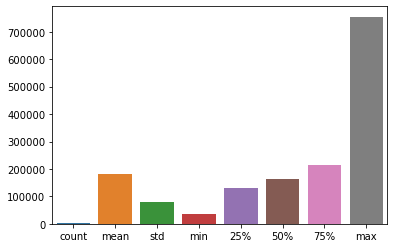

In [6]:
salePrice_analyse = train['SalePrice'].describe()
salePrice_analyse = {"groups" : salePrice_analyse.index,"values" : salePrice_analyse.values}
sns.barplot(x="groups",y = "values", data=salePrice_analyse)

<AxesSubplot:>

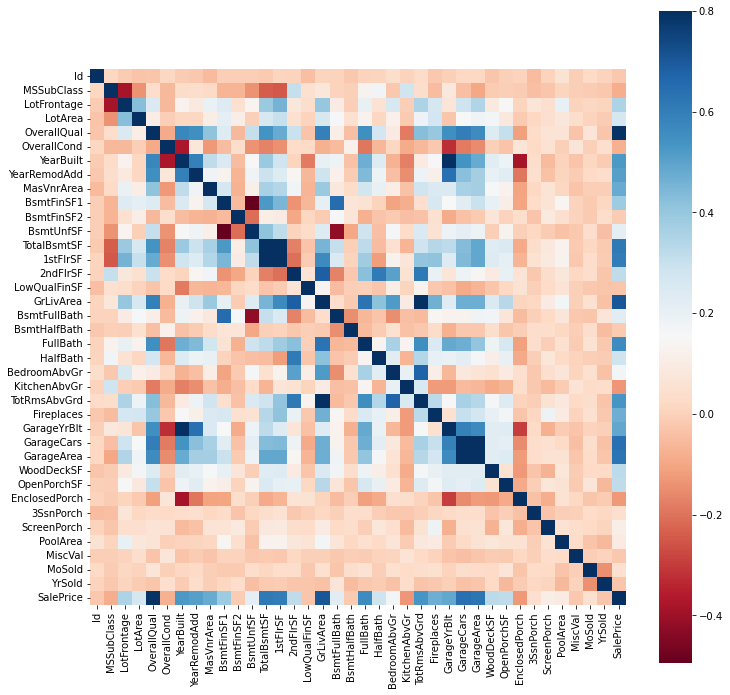

In [7]:
# 查看SalePrice与其他变量相关性
plt.figure(figsize=(12, 12))
train_corr = train.corr()
sns.heatmap(train_corr, square=True, vmax=0.8, cmap='RdBu')

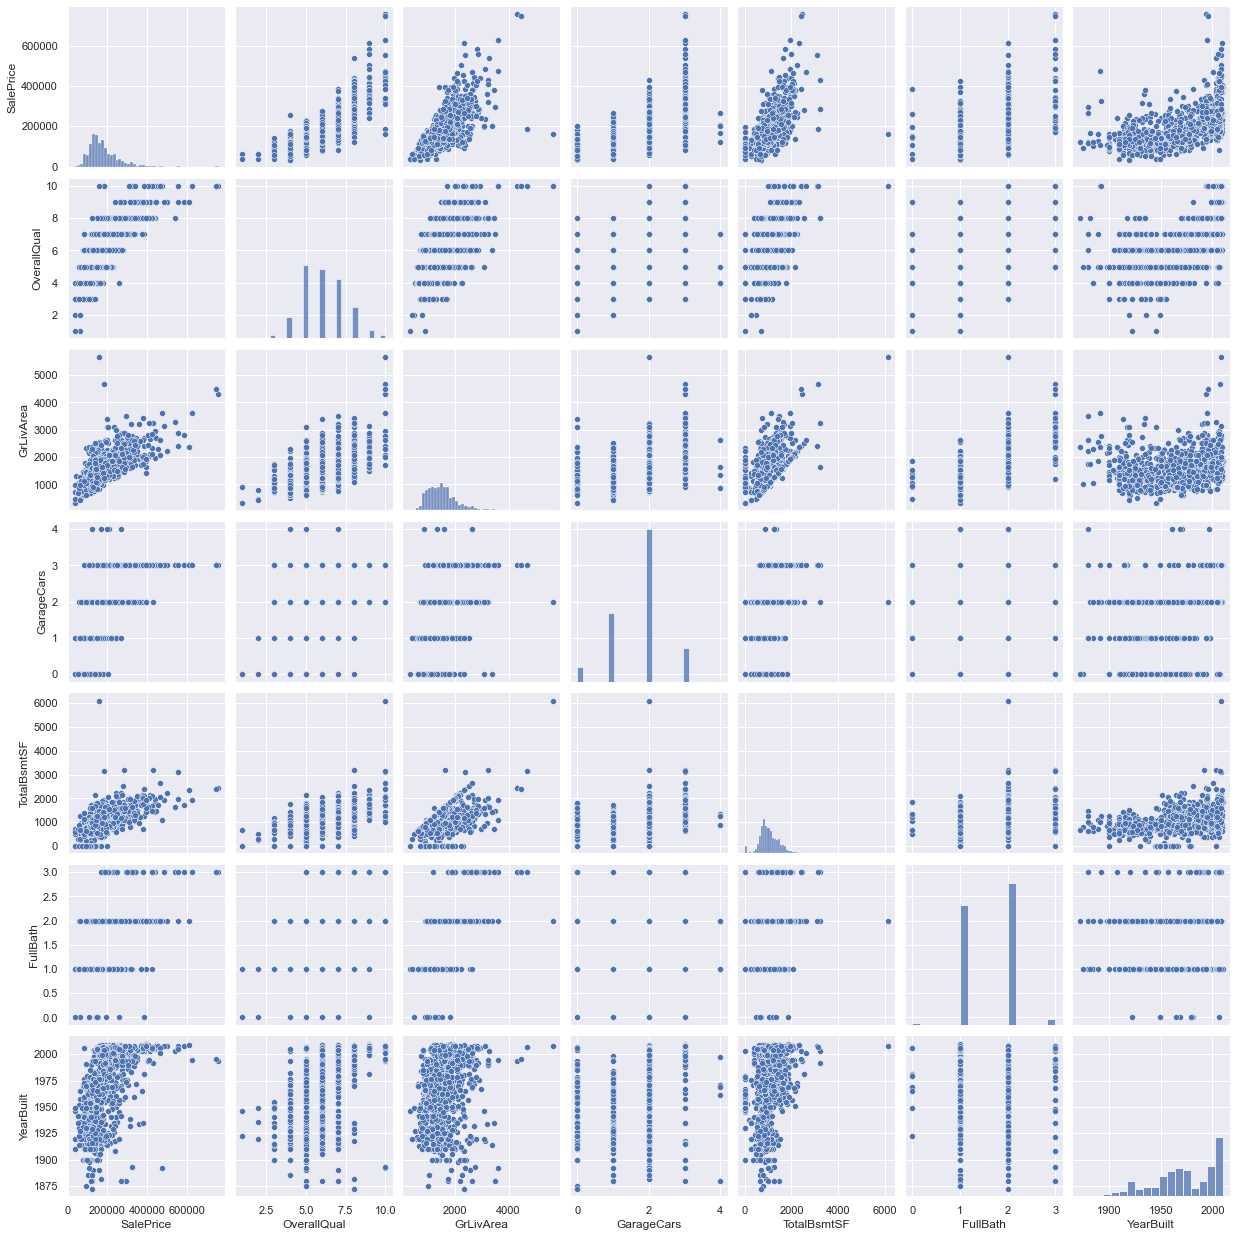

In [8]:
# 变量相关性查看
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], height = 2.5)
plt.show();

In [9]:
# 数据清洗
# 1.1重复值检查和处理
train[train.duplicated().values == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [10]:
# 1.2重复值处理
train = train.drop_duplicates()
# 1.3检查重复值处理是否完毕
train[train.duplicated().values == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


In [11]:
# 2.缺失值处理
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


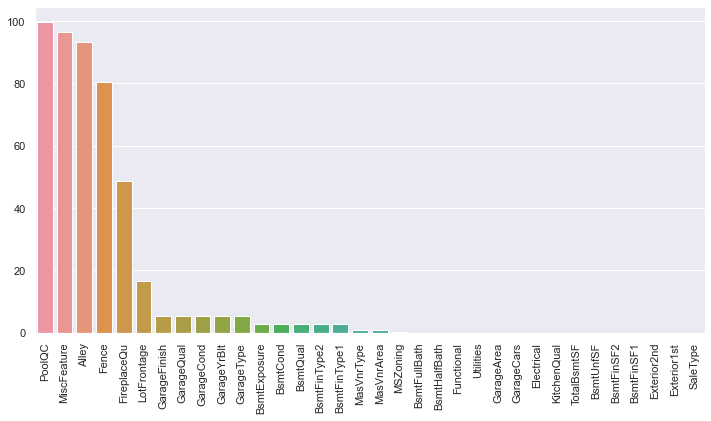

In [12]:
# 拼接数据并将缺失值数量可视化
all_data = pd.concat((train.drop(["SalePrice"], axis=1), test))
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
plt.figure(figsize=(12, 6))
plt.xticks(rotation="90")
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.show()

In [13]:
# 填补缺失值，None\0\众数\中位数\指定值填充，或者去掉该列
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
   train[col].fillna("None", inplace=True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
'BsmtHalfBath', 'MasVnrArea'):
   train[col].fillna(0, inplace=True)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass'):
   train[col].fillna(train[col].mode()[0], inplace=True)
train.drop(['Utilities'], axis=1, inplace=True)
# Functional : NA 意味着典型
all_data["Functional"] = all_data["Functional"].fillna("Typ")
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
   lambda x: x.fillna(x.median()))

# 填补缺失值，None\0\众数\中位数\指定值填充，或者去掉该列
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'):
   test[col].fillna("None", inplace=True)
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath',
'BsmtHalfBath', 'MasVnrArea'):
   test[col].fillna(0, inplace=True)
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'MSSubClass'):
   test[col].fillna(test[col].mode()[0], inplace=True)
# Functional : NA 意味着典型
all_data["Functional"] = all_data["Functional"].fillna("Typ")
test.drop(['Utilities'], axis=1, inplace=True)
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
   lambda x: x.fillna(x.median()))

<AxesSubplot:>

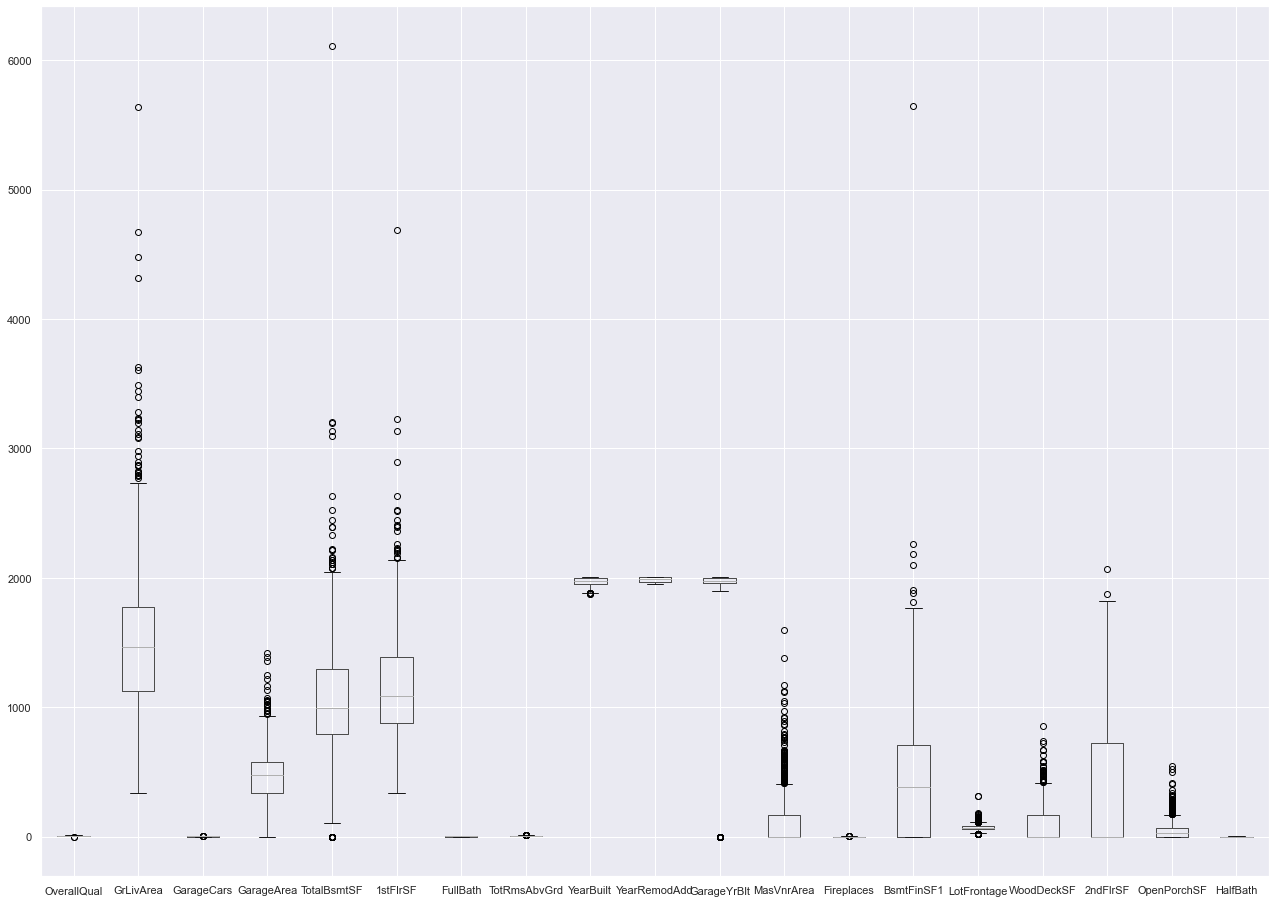

In [14]:
# 3.异常值处理
# 重点关注如下
# OverallQual 房屋设施的完整性
# GrLivArea 居住面积
# GarageCars  车库
# GarageArea  车库面积
# TotalBsmtSF 地下室大小
# 1stFlrSF 1楼面积
# FullBath 厕所面积
# TotRmsAbvGrd 地面上的房间数量
# YearBuilt 建造年份
# YearRemodAdd 重建年份
plt.figure(figsize=(22, 16))
train.boxplot(column=['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd'
                     ,'GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF','HalfBath'
                     ])

<AxesSubplot:>

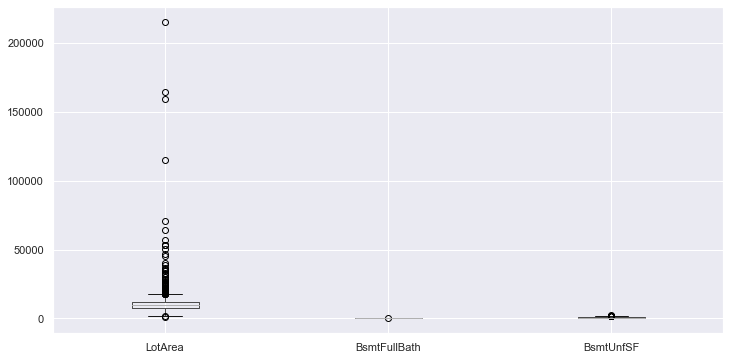

In [15]:
plt.figure(figsize=(12, 6))
train.boxplot(column=['LotArea','BsmtFullBath','BsmtUnfSF'])

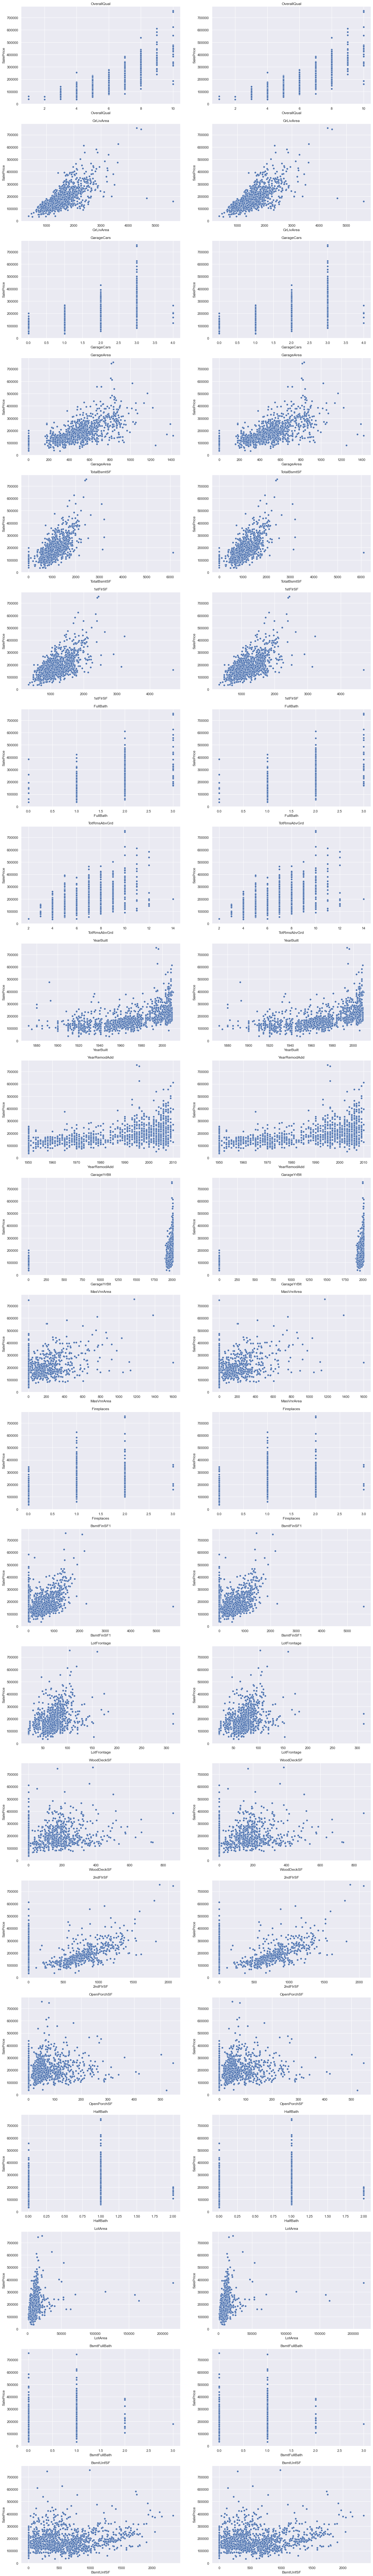

In [16]:
# 对房价有重要意义的变量
# 绘制散点图检查异常值点
colums = ['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd'
                     ,'GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF','HalfBath'
                     ,'LotArea','BsmtFullBath','BsmtUnfSF']
figure,ax=plt.subplots(len(colums),2,figsize=(20,150))
index1 = 0
for item in colums:
    for index2 in [0,1]:
        ax[index1,index2].set_title(item)
        sns.scatterplot(x=train[item],y=train['SalePrice'],ax=ax[index1,index2])
        index2 = index2 + 1
    index1 = index1 + 1
# sns.scatterplot(x=train['OverallQual'],y=train['SalePrice'],ax=ax[0,0])
# sns.scatterplot(x=train['YearBuilt'],y=train['SalePrice'],ax=ax[0,1])
# sns.scatterplot(x=train['TotalBsmtSF'],y=train['SalePrice'],ax=ax[1,0])
# sns.scatterplot(x=train['GrLivArea'],y=train['SalePrice'],ax=ax[1,1])
# sns.scatterplot(x=train['GarageCars'],y=train['SalePrice'],ax=ax[2,0])
# sns.scatterplot(x=train['GarageArea'],y=train['SalePrice'],ax=ax[2,1])
# sns.scatterplot(x=train['TotalBsmtSF'],y=train['SalePrice'],ax=ax[3,0])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['FullBath'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['TotRmsAbvGrd'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['YearBuilt'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['YearRemodAdd'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['GarageYrBlt'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['MasVnrArea'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['Fireplaces'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])
# sns.scatterplot(x=train['1stFlrSF'],y=train['SalePrice'],ax=ax[3,1])

In [17]:
#删除离群点
train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index,inplace=True)
train.drop(train[(train['YearBuilt']<1900) & (train['SalePrice']>400000)].index,inplace=True)
train.drop(train[(train['YearBuilt']>1980) & (train['SalePrice']>700000)].index,inplace=True)
train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index,inplace=True)
train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index,inplace=True)
train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<300000)].index,inplace=True)

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

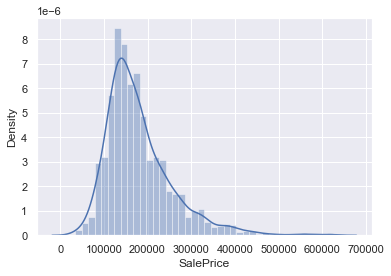

In [18]:
# 4.
# 查看价格的分布情况
sns.distplot(train.SalePrice)

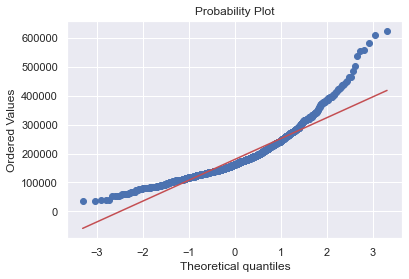

In [19]:
res = stats.probplot(train['SalePrice'], plot=plt)

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

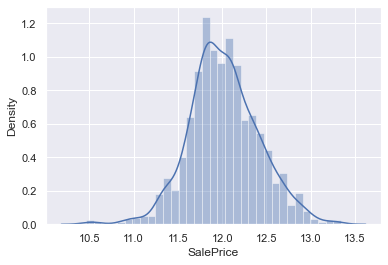

In [20]:
# 将价格转为高斯分布
train["SalePrice"] = np.log1p(train["SalePrice"])
sns.distplot(train.SalePrice)

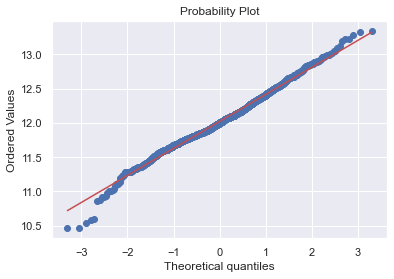

In [21]:
res = stats.probplot(train['SalePrice'], plot=plt)

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

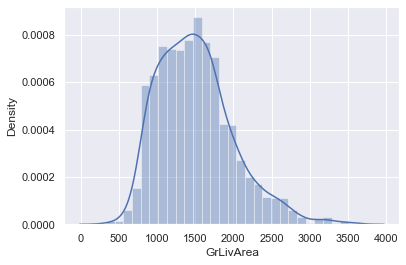

In [22]:
# 继续查看GrLivArea的情况
sns.distplot(train.GrLivArea)

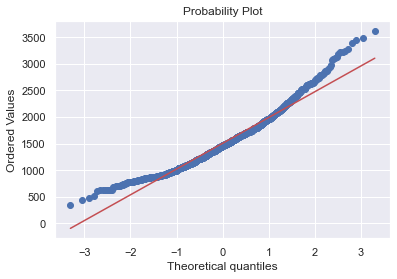

In [23]:
res = stats.probplot(train['GrLivArea'], plot=plt)

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GrLivArea', ylabel='Density'>

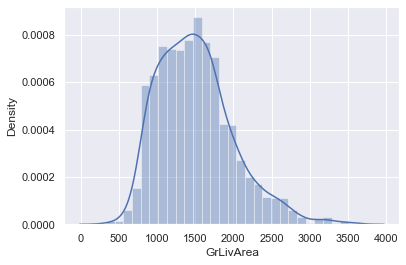

In [24]:
# 将GrLivArea转为高斯分布
# train["GrLivArea"] = np.log(train.GrLivArea + 1)
sns.distplot(train["GrLivArea"])

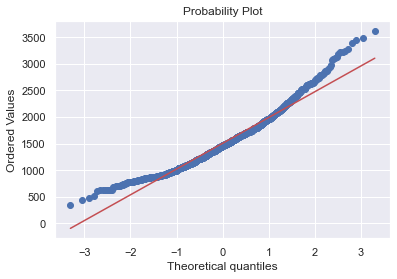

In [25]:
res = stats.probplot(train['GrLivArea'], plot=plt)

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='Density'>

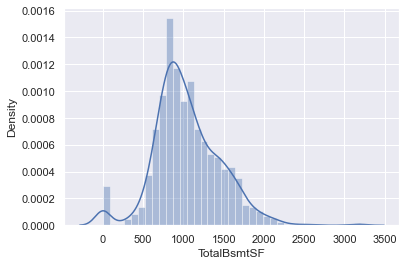

In [26]:
# 继续查看TotalBsmtSF的情况
sns.distplot(train["TotalBsmtSF"])

((array([-3.30340654, -3.04607408, -2.90296155, ...,  2.90296155,
          3.04607408,  3.30340654]),
  array([   0,    0,    0, ..., 3094, 3200, 3206])),
 (405.4335109833574, 1049.6919365954514, 0.9826564123056215))

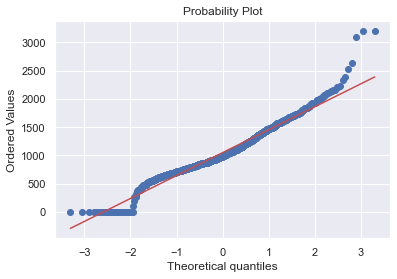

In [27]:
stats.probplot(train['TotalBsmtSF'], plot=plt)

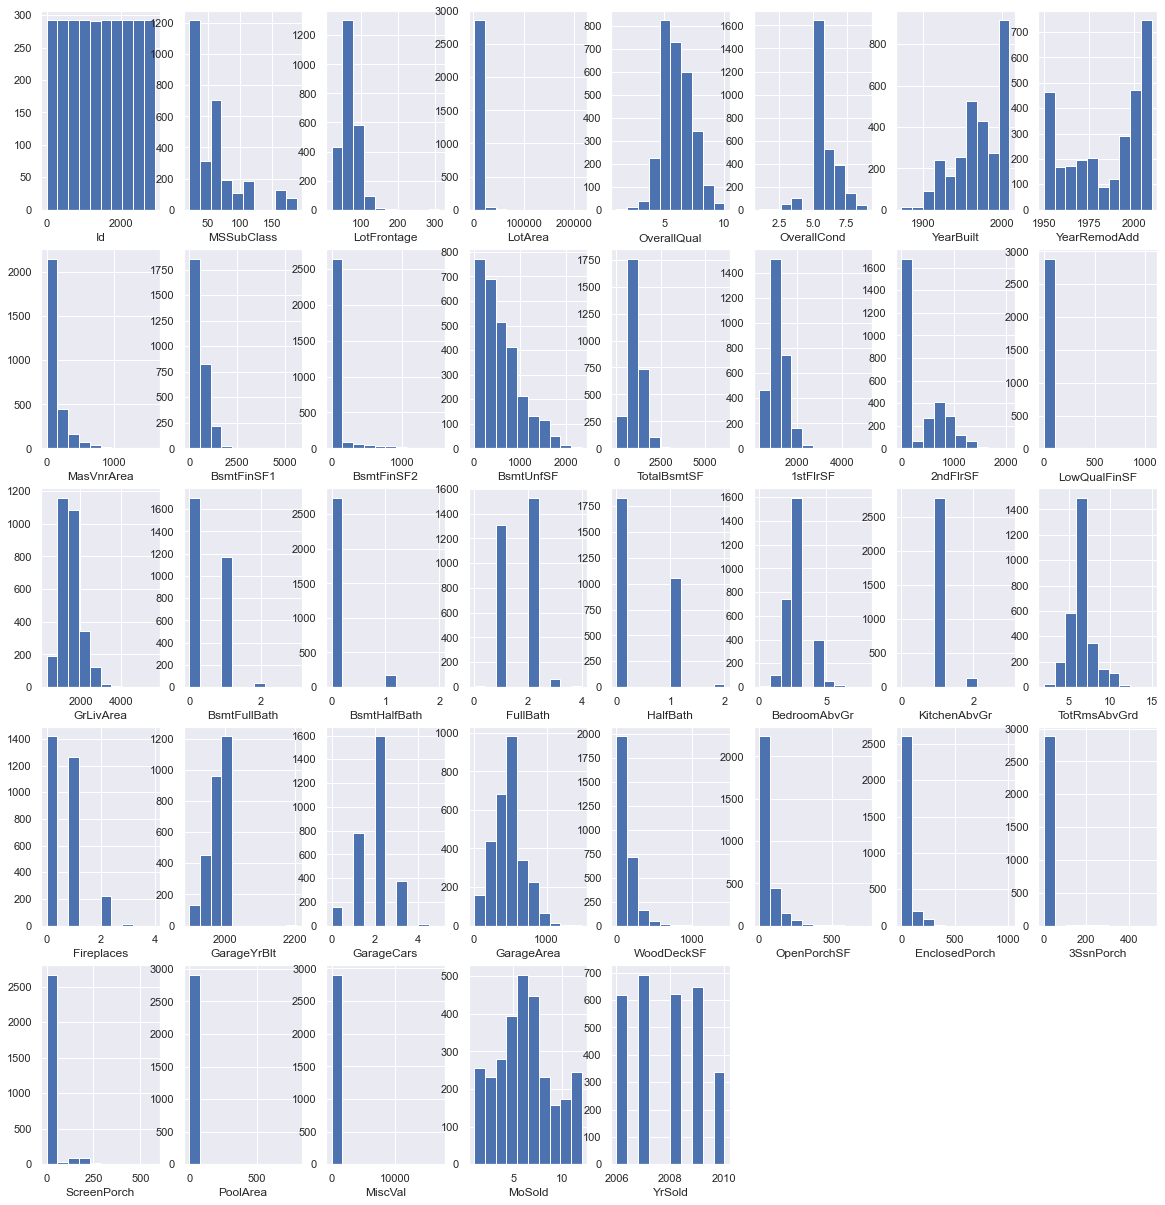

In [28]:
# 数值型特征的数据变换：改变数据分布
numeric_df = all_data.select_dtypes(['int16','int32','int64','float16','float32','float64'])
numeric_cols = numeric_df.columns.tolist()
 
fig = plt.figure(figsize=(20, 30))
for col in numeric_cols:
    ax = fig.add_subplot(7, 8, numeric_cols.index(col)+1)
    ax.set_xlabel(col)
    ax.hist(numeric_df[col])

In [29]:
# 计算各数值型特征的偏度
skewed_cols = all_data[numeric_cols].apply(lambda x: skew(x)).sort_values(ascending=False)
skewed_df = pd.DataFrame({'skew':skewed_cols})
skewed_df

,skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
EnclosedPorch,4.003891
ScreenPorch,3.946694
OpenPorchSF,2.535114
WoodDeckSF,1.842433


In [30]:
# 对偏度绝对值大于0.5的特征进行对数变换
skew_cols = skewed_df[skewed_df['skew'].abs()>1].index.tolist()
for col in skew_cols:
    all_data[col] = np.log1p(all_data[col])

In [31]:
y = train["SalePrice"]

In [32]:
# 构建新的特征
feature = pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)

#增加每个房屋的地下室，一楼和二楼的总面积特征
feature['TotalSF']=feature['TotalBsmtSF'] + feature['1stFlrSF'] + feature['2ndFlrSF']
# 新增房屋改造时间与房屋出售时间间隔
feature['YearsSinceRemodel'] = feature['YrSold'].astype(int) - feature['YearRemodAdd'].astype(int)
# 房间的整体质量
feature['Total_Home_Quality'] = feature['OverallQual'].astype(int) + feature['OverallCond'].astype(int)
# 开放式门廊、围廊、三季门廊、屏风玄关总面积
feature["PorchArea"] = feature["OpenPorchSF"]+feature["EnclosedPorch"]+ feature["3SsnPorch"]+feature["ScreenPorch"] +feature['WoodDeckSF']
feature['Total_Bathrooms'] = (feature['FullBath'] + (0.5 * feature['HalfBath']) +
                               feature['BsmtFullBath'] + (0.5 * feature['BsmtHalfBath']))
# 增添几个特征用于描述房屋内是否存在这些区域空间
feature['haspool'] = feature['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
feature['has2ndfloor'] = feature['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
feature['hasgarage'] = feature['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
feature['hasbsmt'] = feature['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
feature['hasfireplace'] = feature['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

In [33]:
train_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[: train.shape[0]]
test_dummies = pd.get_dummies(pd.concat((train.drop(["SalePrice", "Id"], axis=1), test.drop(["Id"], axis=1)), axis=0)).iloc[train.shape[0]:]

In [34]:
train_dummies

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,6,5,1999,2000,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1456,20,85.0,13175,6,6,1978,1988,119.0,790.0,163.0,...,0,0,0,1,0,0,0,0,1,0
1457,70,66.0,9042,7,9,1941,2006,0.0,275.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1458,20,68.0,9717,5,6,1950,1996,0.0,49.0,1029.0,...,0,0,0,1,0,0,0,0,1,0


In [35]:
# # 标准化-数据处理
# transfer = StandardScaler()
# train_dummies = pd.DataFrame(transfer.fit_transform(train_dummies))
# test_dummies = pd.DataFrame(transfer.fit_transform(test_dummies))

In [36]:
# 借助Ridge寻找离群值
rr = Ridge(alpha=10)
rr.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.11461095350333324

In [37]:
y_pred = rr.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers1 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers1

array([  13,   30,   66,   88,  107,  142,  217,  276,  307,  317,  327,
        364,  409,  430,  460,  477,  493,  530,  557,  584,  624,  628,
        677,  684,  705,  709,  723,  733,  735,  769,  807,  859,  869,
        880,  911,  930,  963,  965, 1056, 1086, 1116, 1175, 1203, 1315,
       1328, 1371, 1374, 1423, 1444])

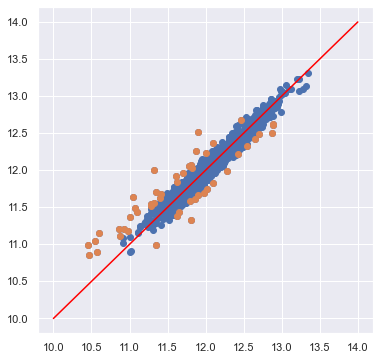

In [38]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers1], y_pred[outliers1])
plt.plot(range(10, 15), range(10, 15), color="red")
plt.show()

In [39]:
# 借助ElasticNet探索离群值
er = ElasticNet(alpha=0.001, l1_ratio=0.58)
er.fit(train_dummies, y)
np.sqrt(-cross_val_score(rr, train_dummies, y, cv=5, scoring="neg_mean_squared_error")).mean()

0.11461095350333324

In [40]:
y_pred = er.predict(train_dummies)
resid = y - y_pred
mean_resid = resid.mean()
std_resid = resid.std()
z = (resid - mean_resid) / std_resid
z = np.array(z)
outliers2 = np.where(abs(z) > abs(z).std() * 3)[0]
outliers2

array([  30,   66,   70,   88,  107,  142,  217,  276,  307,  327,  409,
        430,  450,  460,  477,  493,  530,  557,  584,  624,  628,  658,
        662,  677,  684,  705,  706,  709,  723,  733,  742,  769,  807,
        869,  880,  911,  963,  965, 1056, 1116, 1175, 1203, 1315, 1316,
       1328, 1374, 1414, 1423, 1444])

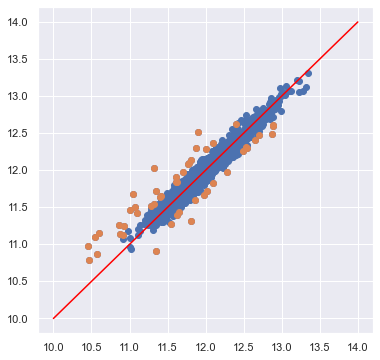

In [41]:
plt.figure(figsize=(6, 6))
plt.scatter(y, y_pred)
plt.scatter(y.iloc[outliers2], y_pred[outliers2])
plt.plot(range(10, 15), range(10, 15), color="red")
plt.show()

In [42]:
outliers = []
for i in outliers1:
    for j in outliers2:
        if i == j:
            outliers.append(i)
outliers

[30,
 66,
 88,
 107,
 142,
 217,
 276,
 307,
 327,
 409,
 430,
 460,
 477,
 493,
 530,
 557,
 584,
 624,
 628,
 677,
 684,
 705,
 709,
 723,
 733,
 769,
 807,
 869,
 880,
 911,
 963,
 965,
 1056,
 1116,
 1175,
 1203,
 1315,
 1328,
 1374,
 1423,
 1444]

In [43]:
# 删除离群点
# 将两次算法预测效果都不好的点作为离群值
train_dummies = train_dummies.drop([13,
 30,
 66,
 88,
 142,
 217,
 276,
 307,
 317,
 327,
 347,
 379,
 430,
 460,
 477,
 493,
 530,
 554,
 556,
 557,
 584,
 585,
 628,
 654,
 677,
 684,
 705,
 706,
 709,
 723,
 733,
 735,
 769,
 859,
 869,
 880,
 893,
 911,
 930,
 963,
 965,
 1056,
 1086,
 1116,
 1175,
 1315,
 1316,
 1335,
 1371,
 1374,
 1423,
 1444])
y = train["SalePrice"]
y = y.drop([13,
 30,
 66,
 88,
 142,
 217,
 276,
 307,
 317,
 327,
 347,
 379,
 430,
 460,
 477,
 493,
 530,
 554,
 556,
 557,
 584,
 585,
 628,
 654,
 677,
 684,
 705,
 706,
 709,
 723,
 733,
 735,
 769,
 859,
 869,
 880,
 893,
 911,
 930,
 963,
 965,
 1056,
 1086,
 1116,
 1175,
 1315,
 1316,
 1335,
 1371,
 1374,
 1423,
 1444])
train_dummies.shape,y.shape

((1399, 299), (1399,))

In [44]:
from sklearn.linear_model import LinearRegression
linearRegressionModel = LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(train_dummies, y, test_size=0.3, random_state=101)
def try_different_method(model):
    model.fit(X_train,y_train)  # 拟合模型
    score = model.score(X_test, y_test)  # 模型评分
    result = model.predict(X_test)  # 测试集结果（目标变量）
#     测试集的均方根误差(真实目标变量与真实预测的目标变量比较)
    print('RMSE is: ', mean_squared_error(y_test, result))
    # 模型评分
    print('score is: ', score)
try_different_method(linearRegressionModel)

train_predict = linearRegressionModel.predict(X_train)

RMSE is:  0.017983948587847423
score is:  0.8808860982978981


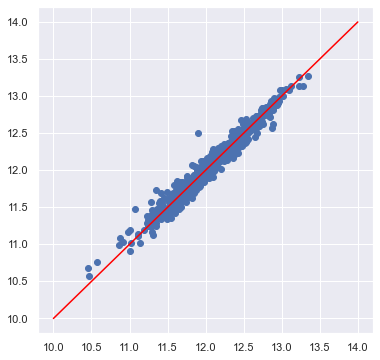

In [45]:
plt.figure(figsize=(6, 6))
plt.scatter(y_train, train_predict)
plt.plot(range(10, 15), range(10, 15), color="red")
plt.show()

In [46]:
test_predict = linearRegressionModel.predict(test_dummies)
pre_df = pd.DataFrame(test_predict)
pre_df["SalePrice"] = test_predict
pre_df = pre_df[["SalePrice"]]
test_predict = np.array(pre_df.SalePrice)
sample_submission["SalePrice"] = np.expm1(test_predict)
sample_submission.to_csv("/Users/ed/Downloads/house-prices-advanced-regression-techniques/submission.csv", index=False)

In [47]:
# n_folds = 5
# def RMSE(alg):
#     kf = KFold(n_folds, shuffle=True, random_state=20).get_n_splits(X_train)
#     rmse= np.sqrt(-cross_val_score(alg, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
#     return(rmse)
# lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
# score = RMSE(lasso)
# print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
# score = RMSE(ENet)
# print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
# score = RMSE(KRR)
# print("\nKRR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)
# score = RMSE(GBoost)
# print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2200,
#                              reg_alpha=0.4640, reg_lambda=0.8571,
#                              subsample=0.5213, silent=1,
#                              random_state =7, nthread = -1)
# score = RMSE(model_xgb)
# print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
# model_lgb = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
#                               learning_rate=0.05, n_estimators=900,
#                               max_bin = 55, bagging_fraction = 0.8,
#                               bagging_freq = 5, feature_fraction = 0.8,
#                               min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
# score = RMSE(model_lgb)
# print("\nLGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

n_folds = 5
def RMSE(alg):
    kf = KFold(n_folds, shuffle=True, random_state=20).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(alg, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score_lasso = RMSE(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score_lasso.mean(), score_lasso.std()))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
score_ENet = RMSE(ENet)
print("\nENet score: {:.4f} ({:.4f})\n".format(score_ENet.mean(), score_ENet.std()))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score_KRR = RMSE(KRR)
print("\nKRR score: {:.4f} ({:.4f})\n".format(score_KRR.mean(), score_KRR.std()))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score_GBoost = RMSE(GBoost)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(score_GBoost.mean(), score_GBoost.std()))
model_xgb = xgboost.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = RMSE(model_xgb)
print("\nXGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
model_lgb = lightgbm.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = RMSE(model_lgb)
print("\nLGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1063 (0.0090)


ENet score: 0.1065 (0.0088)


KRR score: 0.5041 (0.3486)



/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.63451e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.365e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74152e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24046e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,



GBoost score: 0.1128 (0.0114)

[22:33:26] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:33:30] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[22:33:34] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actu

In [48]:
X_train

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
298,60,90.0,11700,6,6,1968,1968,365.0,384.0,175.0,...,0,0,0,1,0,0,0,0,1,0
1089,120,37.0,3316,8,5,2005,2005,0.0,1039.0,0.0,...,0,0,0,1,0,0,0,0,1,0
975,160,73.5,2651,7,5,2000,2000,0.0,641.0,0.0,...,0,0,0,1,0,0,0,0,1,0
125,190,60.0,6780,6,8,1935,1982,0.0,490.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1052,60,100.0,9500,6,6,1964,1978,272.0,442.0,0.0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,120,43.0,3013,7,5,2005,2005,145.0,16.0,0.0,...,0,0,0,1,0,0,0,0,1,0
78,90,72.0,10778,4,5,1968,1968,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
625,20,87.0,10000,6,6,1962,1962,261.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0
1420,60,90.0,11700,6,6,1968,1968,420.0,404.0,0.0,...,0,0,0,1,0,0,0,0,1,0


In [49]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        for model in self.models_:
            model.fit(X, y)

        return self
    
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)  
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = RMSE(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.63451e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.365e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.74152e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


 Averaged base models score: 0.1598 (0.0660)



/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.24046e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,


In [50]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=42)
        
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = RMSE(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.52358e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.12528e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.24353e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=4.68075e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/

Stacking Averaged models score: 0.1023 (0.0111)


In [51]:
model_fit = stacked_averaged_models.fit(X_train, y_train)
result = np.expm1(stacked_averaged_models.predict(test_dummies)) # log(1+x)逆运算

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.55333e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.76448e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10349e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.56926e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/

In [52]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [53]:
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = np.expm1(stacked_averaged_models.predict(test_dummies))
print(rmsle(y_train, stacked_train_pred))

/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.55333e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.76448e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.10349e-16): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.56926e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True,
/Users/ed/miniforge3/envs/python3.9/lib/python3.9/site-packages/

0.06496594856183738


In [54]:
model_xgb.fit(X_train, y_train)
xgb_train_pred = model_xgb.predict(X_train)
xgb_pred = np.expm1(model_xgb.predict(test_dummies))
print(rmsle(y_train, xgb_train_pred))

[22:36:01] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


0.07806279781635182


In [55]:
model_lgb.fit(X_train, y_train)
lgb_train_pred = model_lgb.predict(X_train)
lgb_pred = np.expm1(model_lgb.predict(test_dummies))
print(rmsle(y_train, lgb_train_pred))

[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
0.05857126137795683


In [56]:
print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.30 +
               xgb_train_pred*0.2 + lgb_train_pred*0.5 ))

RMSLE score on train data:
0.06132102908877773


In [57]:
ensemble = stacked_pred*0.30 + xgb_pred*0.20 + lgb_pred*0.50

In [58]:
# 保存预测结果
submission = pd.DataFrame()
submission['Id'] = sample_submission['Id']
submission['SalePrice'] = ensemble
submission.to_csv('/Users/ed/Downloads/house-prices-advanced-regression-techniques/submission2.csv',index=False)

In [59]:
# #决策树可视化
# from sklearn.tree import export_graphviz
# export_graphviz(model_lgb, out_file="tree.dot", 
#                          feature_names=train_dummies.columns[0:],  
#                          class_names=train.SalePrice,  
#                          filled=True, rounded=True, special_characters=True)  
# with open("tree.dot") as f:
#     dot_graph=f.read()
#     graph=graphviz.Source(dot_graph)
# model_xgb.fit(train_dummies,y)
# xgboost.to_graphviz(model_xgb, num_trees=1)

<AxesSubplot:xlabel='groups', ylabel='values'>

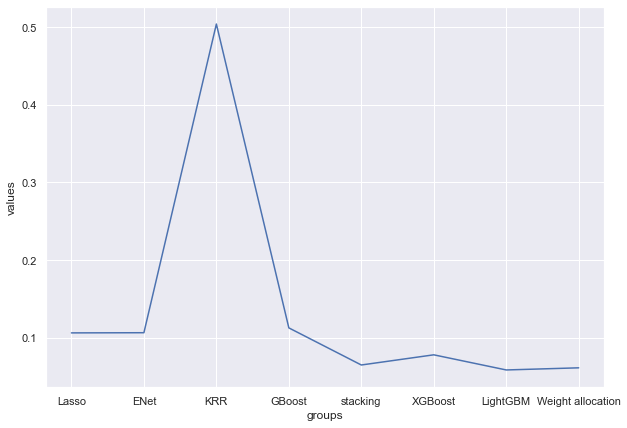

In [60]:
model_score_array = {"groups":["Lasso","ENet","KRR","GBoost","stacking","XGBoost","LightGBM","Weight allocation"],"values":[score_lasso.mean(),score_ENet.mean(),score_KRR.mean(),score_GBoost.mean(),rmsle(y_train, stacked_train_pred),rmsle(y_train, xgb_train_pred),rmsle(y_train, lgb_train_pred),rmsle(y_train,stacked_train_pred*0.30 +
               xgb_train_pred*0.2 + lgb_train_pred*0.5 )]}
model_score = pd.DataFrame(model_score_array)
plt.figure(figsize=(10, 7))
sns.lineplot(x = "groups",y="values", data=model_score)